In [37]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class YoloDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.images = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_file = self.images[idx]
        img_path = os.path.join(self.data_dir, img_file)
        label_file = img_file.replace('.jpg', '.txt')
        label_path = os.path.join(self.data_dir, label_file)
        
        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape
        
        # Load labels
        boxes = []
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                boxes.append([x_center, y_center, width, height, int(class_id)])
        boxes = np.array(boxes)
        
        # Apply transformations
        if self.transform:
            transformed = self.transform(image=image, bboxes=boxes[:, :4], class_labels=boxes[:, 4])
            image = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['class_labels']
            
            # Convert to tensor
            targets = []
            for bbox, label in zip(boxes, labels):
                targets.append([label, *bbox])
            targets = torch.tensor(targets, dtype=torch.float32)
            
            return image, targets
        else:
            return image, torch.tensor(boxes, dtype=torch.float32)


In [45]:
def plot_image_with_boxes(image, targets):
    #Convert tensor to numpy for plotting
    image_np = image.permute(0, 1, 2).numpy()
    image_np = (image_np * 255).astype(np.uint8)    #Convert to [0, 255] range if needed

    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)
    plt.axis('off')

    #Convert targets tensor to numpy
    targets_np = targets.numpy()

    #Draw bounding boxes
    for target in targets_np:
        label, x_center, y_center, width, height = target
        x_center *= image_np.shape[1]
        y_center *= image_np.shape[0]
        width *= image_np.shape[1]
        height *= image_np.shape[0]

        x1 = int(x_center - width/2)
        y1 = int(y_center - height/2)
        x2 = int(x_center + width/2)
        y2 = int(y_center + height/2)

        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
        plt.text(x1, y1, "elephant", color='red', fontsize=12, bbox=dict(facecolor='yellow', alpha = 0.5))

    plt.show()

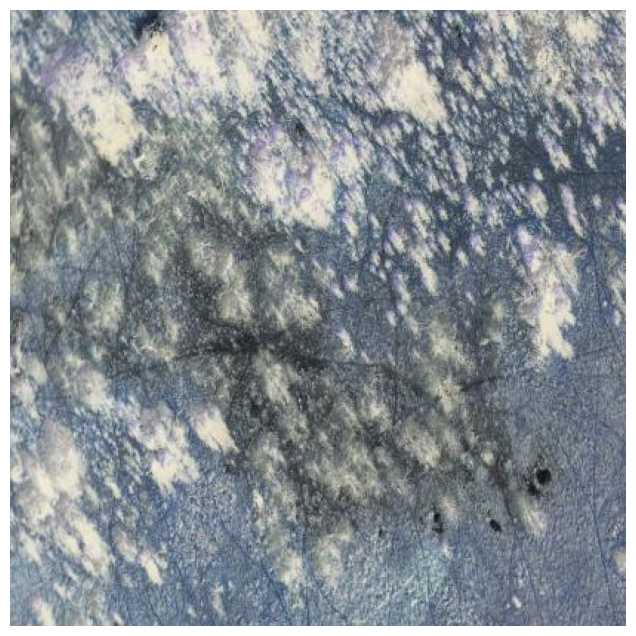

In [46]:
import os
from torch.utils.data import DataLoader

#Define the base path for data
base_data_path = r"C:\Users\aurel\Downloads\WildGuard\ml-ai"

#Define paths
valid_data_path = os.path.join(base_data_path, 'valid')
train_data_path = os.path.join(base_data_path, 'train')
test_data_path = os.path.join(base_data_path, 'test')

#Instantiate the dataset and data loader
valid_dataset = YoloDataset(data_dir=valid_data_path, transform=None)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=1, shuffle=True)

#Retrieve a sample from the data loader
for images, targets in valid_loader:
    #Assuming the data loader returns a batch of 1 image
    image = images[0]
    target = targets[0]

    #Visualize the sample
    plot_image_with_boxes(image, target)
    break       #Exit after visualizing one sample

In [50]:
import yaml
from yolov5 import train

#Create YAML config file for dataset
data_yaml = dict(
    train= r"C:\Users\aurel\Downloads\WildGuard\ml-ai\train",
    val= r"C:\Users\aurel\Downloads\WildGuard\ml-ai\valid",
    test= r"C:\Users\aurel\Downloads\WildGuard\ml-ai\test",
    nc= 1, #number of classes
    names= ['elephant']
)

with open(r"C:\Users\aurel\Downloads\WildGuard\ml-ai\elephant_dataset.yaml", 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=False)
    